In [1]:
import streamlit as st
import torch
import pandas as pd
import numpy as np
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import pickle
from PIL import Image
import os

In [2]:
# 1. Load mô hình NLP

nlp = spacy.load("en_core_web_sm")

C:\Users\admin\anaconda3\envs\coco_kg\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [3]:
# 1.1. Phân tích cú pháp từ SpaCy

caption = "a boy and a girl playing with a dog and a ball"
doc = nlp(caption)

print("Dependency parsing result:\n")
print(f"{'Token':<12}{'POS':<8}{'Dep':<12}{'Head':<12}")
print("-" * 44)
for token in doc:
    print(f"{token.text:<12}{token.pos_:<8}{token.dep_:<12}{token.head.text:<12}")

Dependency parsing result:

Token       POS     Dep         Head        
--------------------------------------------
a           DET     det         boy         
boy         NOUN    ROOT        boy         
and         CCONJ   cc          boy         
a           DET     det         girl        
girl        NOUN    conj        boy         
playing     VERB    acl         girl        
with        ADP     prep        playing     
a           DET     det         dog         
dog         NOUN    pobj        with        
and         CCONJ   cc          dog         
a           DET     det         ball        
ball        NOUN    conj        dog         


In [4]:
caption = "a boy, a girl and a dog are playing together"
doc = nlp(caption)

print("Dependency parsing result:\n")
print(f"{'Token':<12}{'POS':<8}{'Dep':<12}{'Head':<12}")
print("-" * 44)
for token in doc:
    print(f"{token.text:<12}{token.pos_:<8}{token.dep_:<12}{token.head.text:<12}")

Dependency parsing result:

Token       POS     Dep         Head        
--------------------------------------------
a           DET     det         boy         
boy         NOUN    nsubj       playing     
,           PUNCT   punct       boy         
a           DET     det         girl        
girl        NOUN    appos       boy         
and         CCONJ   cc          girl        
a           DET     det         dog         
dog         NOUN    conj        girl        
are         AUX     aux         playing     
playing     VERB    ROOT        playing     
together    ADV     advmod      playing     


In [14]:
# 2. Hàm trích triplet từ caption

def extract_multiple_triplets_from_caption(caption):
    doc = nlp(caption)
    subjects, predicate, objects = [], None, []

    # === Bắt subject chính là ROOT hoặc nsubj
    root_noun = None
    for token in doc:
        if token.dep_ in ("nsubj", "nsubjpass") and token.pos_ == "NOUN":
            root_noun = token
            subjects.append(token.text.lower())
            break
        elif token.dep_ == "ROOT" and token.pos_ == "NOUN":
            root_noun = token
            subjects.append(token.text.lower())
            break

    # === Thêm subject phối hợp nếu là appos hoặc conj của subject chính hoặc các subject liên quan
    if root_noun:
        extended_subjects = set()
        extended_subjects.add(root_noun)

        for token in doc:
            if token.dep_ == "appos" and token.head == root_noun and token.pos_ == "NOUN":
                subjects.append(token.text.lower())
                extended_subjects.add(token)

        for token in doc:
            if token.dep_ == "conj" and token.head in extended_subjects and token.pos_ == "NOUN":
                subjects.append(token.text.lower())

    # === Tìm predicate: ưu tiên ROOT VERB hoặc acl
    for token in doc:
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            predicate = token.text.lower()
            break
    if predicate is None:
        for token in doc:
            if token.dep_ == "acl" and token.pos_ == "VERB":
                predicate = token.text.lower()
                break

    # === Object: dobj, pobj, attr, hoặc là tân ngữ của giới từ (prep)
    for token in doc:
        if token.dep_ in ("dobj", "pobj", "attr") and token.pos_ == "NOUN":
            objects.append(token.text.lower())
        elif token.dep_ == "conj" and token.head.dep_ in ("dobj", "pobj", "attr"):
            objects.append(token.text.lower())

    # === Trường hợp không có predicate, nhưng có giới từ + tân ngữ (e.g., with sunglasses)
    if predicate is None and not objects:
        for token in doc:
            if token.dep_ == "prep" and token.head in doc:
                prep = token
                pobj = next((t for t in token.children if t.dep_ == "pobj" and t.pos_ == "NOUN"), None)
                if prep and pobj and root_noun:
                    predicate = None
                    objects.append(pobj.text.lower())

    # === Sinh triplet
    triplets = []
    if subjects and objects:
        for subj in subjects:
            for obj in objects:
                triplets.append((subj, predicate, obj))
    elif subjects:
        triplets = [(subj, predicate, None) for subj in subjects]

    return triplets

In [78]:
# 2. Hàm trích triplet từ caption

def extract_multiple_triplets_from_caption(caption):
    doc = nlp(caption)
    triplets = []

    for sent in doc.sents:
        # 1. subject - verb - object
        for token in sent:
            if token.dep_ == "nsubj" and token.head.pos_ == "VERB":
                subject = token.text.lower()
                predicate = token.head.text.lower()
                obj = None
                for child in token.head.children:
                    if child.dep_ in ("dobj", "attr") and child.pos_ in ("NOUN", "PRON"):
                        obj = child.text.lower()
                        triplets.append((subject, predicate, obj))
                    elif child.dep_ == "prep":
                        pobj = next((t for t in child.children if t.dep_ == "pobj"), None)
                        if pobj:
                            if obj:
                                triplets.append((obj, child.text.lower(), pobj.text.lower()))
                                for conj in pobj.children:
                                    if conj.dep_ == "conj":
                                        triplets.append((obj, child.text.lower(), conj.text.lower()))
                            else:
                                triplets.append((subject, predicate, pobj.text.lower()))

        # 2. noun - prep - noun
        for token in sent:
            if token.dep_ == "prep" and token.head.pos_ == "NOUN":
                pobj = next((child for child in token.children if child.dep_ == "pobj"), None)
                if pobj:
                    triplets.append((token.head.text.lower(), token.text.lower(), pobj.text.lower()))
                    for conj in pobj.children:
                        if conj.dep_ == "conj":
                            triplets.append((token.head.text.lower(), token.text.lower(), conj.text.lower()))

        # 3. noun - and - noun
        for token in sent:
            if token.dep_ == "conj" and token.head.pos_ == "NOUN":
                for parent in token.head.children:
                    if parent.dep_ in ("det", "amod"):
                        triplets.append((token.head.text.lower(), "and", token.text.lower()))

        # 4. amod verb + npadvmod
        for token in sent:
            if token.dep_ == "amod" and token.head.pos_ == "NOUN" and token.pos_ == "VERB":
                modifier = next((child for child in token.children if child.dep_ == "npadvmod"), None)
                if modifier:
                    triplets.append((token.head.text.lower(), token.text.lower(), modifier.text.lower()))

        # 5. tính từ bổ nghĩa cho danh từ (e.g., fluffy sheep)
        for token in sent:
            if token.dep_ == "amod" and token.head.pos_ == "NOUN":
                triplets.append((token.head.text.lower(), "amod", token.text.lower()))

        # 6. advcl (e.g., while others wait)
        for token in sent:
            if token.dep_ == "advcl" and token.pos_ == "VERB":
                verb = token.text.lower()
                subject = None
                obj = None
                for child in token.children:
                    if child.dep_ == "nsubj":
                        subject = child.text.lower()
                    elif child.dep_ in ("dobj", "attr", "pobj") and child.pos_ == "NOUN":
                        obj = child.text.lower()
                if subject:
                    triplets.append((subject, verb, obj))

        # 7. acl + to + amod/xcomp → chuyển động từ bổ sung
        for token in sent:
            if token.pos_ == "VERB" and token.dep_ == "acl":
                subj = token.head.text.lower()
                verb1 = token.text.lower()
                triplets.append((subj, verb1, None))

                for child in token.children:
                    if child.dep_ == "prep" and child.text.lower() == "to":
                        for grandchild in child.children:
                            if grandchild.dep_ in ("amod", "xcomp") and grandchild.head.pos_ == "NOUN":
                                triplets.append((subj, grandchild.text.lower(), grandchild.head.text.lower()))

    return triplets

In [15]:
# 2.1. Hàm test caption

test_captions = [
    "a man riding a horse",
    "a dog chasing a ball",
    "a child eating pizza",
    "a woman holding a phone",
    "an airplane flying in the sky",
    "the group drives a car",
    "a cat sleeps on the couch",
    "a boy with a kite",
    "a person riding a bike",
    "a man with sunglasses"
]

for caption in test_captions:
    triplets = extract_multiple_triplets_from_caption(caption)
    print(f"Caption: {caption}")
    if triplets:
        for s, p, o in triplets:
            print(f"Triplet: ({s}, {p if p else 'None'}, {o if o else 'None'})")
    else:
        print("Triplet: (Không tìm được triplet)")
    print()

Caption: a man riding a horse
Triplet: (man, riding, horse)

Caption: a dog chasing a ball
Triplet: (dog, chasing, ball)

Caption: a child eating pizza
Triplet: (child, eating, pizza)

Caption: a woman holding a phone
Triplet: (woman, holding, phone)

Caption: an airplane flying in the sky
Triplet: (airplane, flying, sky)

Caption: the group drives a car
Triplet: (group, drives, car)

Caption: a cat sleeps on the couch
Triplet: (cat, sleeps, couch)

Caption: a boy with a kite
Triplet: (boy, None, kite)

Caption: a person riding a bike
Triplet: (person, riding, bike)

Caption: a man with sunglasses
Triplet: (man, None, sunglasses)



In [16]:
# 2.2. Test nhiều subject và nhiều object

caption = "a boy and a girl playing with a dog and a ball"
triplets = extract_multiple_triplets_from_caption(caption)
for t in triplets:
    print("Triplet:", t)

Triplet: ('boy', 'playing', 'dog')
Triplet: ('boy', 'playing', 'ball')
Triplet: ('girl', 'playing', 'dog')
Triplet: ('girl', 'playing', 'ball')


In [17]:
caption = "a boy, a girl and a dog are playing together"
triplets = extract_multiple_triplets_from_caption(caption)
for t in triplets:
    print("Triplet:", t)

Triplet: ('boy', 'playing', None)
Triplet: ('girl', 'playing', None)
Triplet: ('dog', 'playing', None)


In [18]:
# 2.3. Bản đồ đồng nghĩa

synonym_map = {
    "man": "person",
    "woman": "person",
    "boy": "person",
    "girl": "person",
    "child": "person",
    "guy": "person",
    "lady": "person",
    "kid": "person",
    "biker": "person",
    "skier": "person",

    "bike": "bicycle",
    "biker": "bicycle",
    "motorcycle": "motorbike",
    "motorbike": "motorbike",
    "motorcyclist": "motorbike",

    "pony": "horse",
    "donkey": "horse",
    "foal": "horse",
    "colt": "horse",

    "puppy": "dog",
    "pup": "dog",
    "hound": "dog",
    "canine": "dog",

    "kitten": "cat",
    "feline": "cat",

    "automobile": "car",
    "vehicle": "car",
    "van": "car",
    "truck": "car",
    "suv": "car",

    "laptop": "computer",
    "monitor": "computer",
    "desktop": "computer",
    "pc": "computer",

    "cellphone": "phone",
    "mobile": "phone",
    "smartphone": "phone",

    "sofa": "couch",
    "loveseat": "couch",

    "plane": "airplane",
    "aircraft": "airplane",
    "jet": "airplane",

    "boat": "ship",
    "canoe": "boat",
    "kayak": "boat",
    "raft": "boat",

    "streetcar": "train",
    "locomotive": "train",
    "subway": "train",

    "board": "surfboard",
    "snowboarder": "snowboard",
    "skateboarder": "skateboard"
}

In [19]:
# 3. Load dữ liệu cần thiết
import pickle
import numpy as np
from collections import defaultdict

def load_data():
    with open("saved_model_GAT/entity_encoder.pkl", "rb") as f:
        entity_encoder = pickle.load(f)

    node_embeddings = np.load("saved_model_GAT/node_embeddings.npy")

    with open("saved_model_GAT/entity_idx_to_images.pkl", "rb") as f:
        entity_idx_to_images = pickle.load(f)

    return entity_encoder, node_embeddings, entity_idx_to_images

In [20]:
# 3.1. Test dữ liệu đã load của entity_encoder
entity_encoder, node_embeddings, entity_idx_to_images = load_data()

print("man" in entity_encoder.classes_)
print("horse" in entity_encoder.classes_)
print("riding" in entity_encoder.classes_)
print("horrr" in entity_encoder.classes_)

True
True
True
False


In [21]:
entity_id_person = None
if "person" in entity_encoder.classes_:
    entity_id_person = list(entity_encoder.classes_).index("person")

entity_id_person

748

In [47]:
entity_id_boy = None
if "boy" in entity_encoder.classes_:
    entity_id_boy = list(entity_encoder.classes_).index("boy")

entity_id_boy

134

In [22]:
entity_id_horse = None
if "horse" in entity_encoder.classes_:
    entity_id_horse = list(entity_encoder.classes_).index("horse")

entity_id_horse

497

In [39]:
entity_id_riding = None
if "horse" in entity_encoder.classes_:
    entity_id_riding = list(entity_encoder.classes_).index("riding")

entity_id_riding

851

In [40]:
# 3.2. Test dữ liệu đã load của entity_idx_to_images
    
print(entity_id_person in entity_idx_to_images)  # person
print(entity_id_horse in entity_idx_to_images)  # horse
print(entity_id_riding in entity_idx_to_images)  # riding

True
True
True


In [42]:
# 3.3. Test dữ liệu đã load của entity_idx_to_images

print("Ảnh của person:", entity_idx_to_images.get(entity_id_person, []))
print("\nẢnh của horse:", entity_idx_to_images.get(entity_id_horse, []))

Ảnh của person: {360960, 243204, 301061, 553990, 161799, 300039, 468501, 450075, 523807, 331817, 9772, 439854, 27696, 576052, 535094, 576566, 86582, 289343, 484415, 449603, 199236, 230983, 206411, 421455, 437331, 83540, 422998, 220764, 476258, 441442, 40036, 329827, 390246, 424551, 30828, 342128, 501368, 491130, 438907, 191614, 439426, 283268, 161925, 193674, 454798, 199310, 257169, 53909, 176799, 511647, 246436, 390826, 544444, 143556, 508101, 580294, 402118, 183500, 493772, 341196, 145620, 51938, 309484, 554735, 579321, 181499, 50943, 509699, 148739, 558854, 51976, 785, 380706, 377635, 570664, 30504, 426795, 248112, 462643, 545594, 326462, 494913, 65350, 57672, 81738, 21839, 489305, 523100, 261982, 112997, 198510, 357238, 149375, 244099, 378244, 172935, 426376, 369037, 146831, 144784, 80273, 137106, 94614, 5529, 537506, 2473, 309678, 251824, 454067, 475064, 528314, 441286, 455624, 502737, 476119, 248284, 210915, 112110, 375278, 140270, 242678, 108026, 255483}

Ảnh của horse: {29187, 

In [26]:
# 3.4. Test dữ liệu đã được lưu của entity_idx_to_images

# Entity ID của "person" và "horse"
person_id = entity_id_person
horse_id = entity_id_horse

# Lấy ảnh giao nhau
person_images = set(entity_idx_to_images.get(person_id, []))
horse_images = set(entity_idx_to_images.get(horse_id, []))
intersection_images = list(person_images & horse_images)

# In ra tên ảnh đúng định dạng COCO (12 chữ số + .jpg)
print("Danh sách ảnh có cả 'person' và 'horse':\n")
for img_id in intersection_images:
    filename = f"{int(img_id):012}.jpg"
    print(filename)

Danh sách ảnh có cả 'person' và 'horse':

000000441442.jpg
000000244099.jpg
000000199236.jpg
000000040036.jpg
000000553990.jpg
000000454798.jpg
000000140270.jpg
000000576052.jpg
000000242678.jpg
000000191614.jpg


In [27]:
# 3.5. Kiểm tra xem "riding" có được encode thành entity_id không

word = "riding"

if word in entity_encoder.classes_:
    entity_id_riding = entity_encoder.transform([word])[0]
    message = f"'{word}' tồn tại trong entity_encoder → entity_id = {entity_id_riding}"
else:
    entity_id_riding = None
    message = f"'{word}' KHÔNG tồn tại trong entity_encoder"

entity_id_riding, message

(851, "'riding' tồn tại trong entity_encoder → entity_id = 851")

In [31]:
word = "ride"

if word in entity_encoder.classes_:
    entity_id_ride = entity_encoder.transform([word])[0]
    message = f"'{word}' tồn tại trong entity_encoder → entity_id = {entity_id_ride}"
else:
    entity_id_ride = None
    message = f"'{word}' KHÔNG tồn tại trong entity_encoder"

entity_id_ride, message

(848, "'ride' tồn tại trong entity_encoder → entity_id = 848")

In [28]:
word = "playing"

if word in entity_encoder.classes_:
    entity_id_playing = entity_encoder.transform([word])[0]
    message = f"'{word}' tồn tại trong entity_encoder → entity_id = {entity_id_playing}"
else:
    entity_id_playing = None
    message = f"'{word}' KHÔNG tồn tại trong entity_encoder"

entity_id_playing, message

(None, "'playing' KHÔNG tồn tại trong entity_encoder")

In [30]:
word = "play"

if word in entity_encoder.classes_:
    entity_id_play = entity_encoder.transform([word])[0]
    message = f"'{word}' tồn tại trong entity_encoder → entity_id = {entity_id_play}"
else:
    entity_id_playing = None
    message = f"'{word}' KHÔNG tồn tại trong entity_encoder"

entity_id_play, message

(790, "'play' tồn tại trong entity_encoder → entity_id = 790")

In [57]:
def inspect_triplets_from_caption(caption, entity_encoder, entity_idx_to_images, synonym_map):
    triplets = extract_multiple_triplets_from_caption(caption)
    print(f"\n Caption: {caption}")
    print(f"Số triplet trích được: {len(triplets)}")
    for t in triplets:
        print(" -", t)

    def try_find(word):
        try:
            return entity_encoder.transform([word])[0]
        except:
            return None

    def get_all_ids(label, original, synonym=None):
        ids = set()
        print(f"\n Kiểm tra {label}: '{original}'")

        word_lower = original.lower()
        idx_orig = try_find(word_lower)
        if idx_orig is not None:
            count = len(entity_idx_to_images.get(idx_orig, []))
            print(f"  Từ gốc: '{word_lower}' → entity_id = {idx_orig} → {count} ảnh")
            ids.add(idx_orig)
        else:
            print(f"  Không tìm thấy từ gốc: '{word_lower}'")

        if synonym:
            syn_word = synonym.lower()
            if syn_word != word_lower:
                idx_syn = try_find(syn_word)
                if idx_syn is not None and idx_syn not in ids:
                    count = len(entity_idx_to_images.get(idx_syn, []))
                    print(f"  Từ đồng nghĩa: '{syn_word}' → entity_id = {idx_syn} → {count} ảnh")
                    ids.add(idx_syn)
                elif idx_syn is None:
                    print(f"  Không tìm thấy từ đồng nghĩa: '{syn_word}'")

        return ids

    for subj_raw, pred_raw, obj_raw in triplets:
        print(f"\n===> Triplet: ({subj_raw}, {pred_raw}, {obj_raw})")

        # Lấy từ đồng nghĩa nếu có
        subj_syn = synonym_map.get(subj_raw.lower())
        pred_syn = synonym_map.get(pred_raw.lower())
        obj_syn = synonym_map.get(obj_raw.lower())

        # Lấy tất cả ID có thể từ subject, predicate, object
        subj_ids = get_all_ids("subject", subj_raw, subj_syn)
        pred_ids = get_all_ids("predicate", pred_raw, pred_syn)
        obj_ids = get_all_ids("object", obj_raw, obj_syn)

        # Lấy ảnh từ các ID
        subj_imgs = set()
        for sid in subj_ids:
            subj_imgs.update(entity_idx_to_images.get(sid, []))

        pred_imgs = set()
        for pid in pred_ids:
            pred_imgs.update(entity_idx_to_images.get(pid, []))

        obj_imgs = set()
        for oid in obj_ids:
            obj_imgs.update(entity_idx_to_images.get(oid, []))

In [58]:
inspect_triplets_from_caption("a boy riding a pony", entity_encoder, entity_idx_to_images, synonym_map)


 Caption: a boy riding a pony
Số triplet trích được: 1
 - ('boy', 'riding', 'pony')

===> Triplet: (boy, riding, pony)

 Kiểm tra subject: 'boy'
  Từ gốc: 'boy' → entity_id = 134 → 65 ảnh
  Từ đồng nghĩa: 'person' → entity_id = 748 → 123 ảnh

 Kiểm tra predicate: 'riding'
  Từ gốc: 'riding' → entity_id = 851 → 1 ảnh

 Kiểm tra object: 'pony'
  Từ gốc: 'pony' → entity_id = 799 → 2 ảnh
  Từ đồng nghĩa: 'horse' → entity_id = 497 → 32 ảnh


In [81]:
def inspect_triplets_from_caption(caption, entity_encoder, entity_idx_to_images, synonym_map):
    triplets = extract_multiple_triplets_from_caption(caption)
    print(f"\n Caption: {caption}")
    print(f"Số triplet trích được: {len(triplets)}")
    for t in triplets:
        print(" -", t)

    def try_find(word):
        try:
            return entity_encoder.transform([word])[0]
        except:
            return None

    def get_all_ids(label, original, synonym=None):
        ids = set()
        print(f"\n Kiểm tra {label}: '{original}'")

        word_lower = original.lower()
        idx_orig = try_find(word_lower)
        if idx_orig is not None:
            count = len(entity_idx_to_images.get(idx_orig, []))
            print(f"  Từ gốc: '{word_lower}' → entity_id = {idx_orig} → {count} ảnh")
            ids.add(idx_orig)
        else:
            print(f"  Không tìm thấy từ gốc: '{word_lower}'")

        if synonym:
            syn_word = synonym.lower()
            if syn_word != word_lower:
                idx_syn = try_find(syn_word)
                if idx_syn is not None and idx_syn not in ids:
                    count = len(entity_idx_to_images.get(idx_syn, []))
                    print(f"  Từ đồng nghĩa: '{syn_word}' → entity_id = {idx_syn} → {count} ảnh")
                    ids.add(idx_syn)
                elif idx_syn is None:
                    print(f"  Không tìm thấy từ đồng nghĩa: '{syn_word}'")

        return ids

    def print_intersection(title, set1, set2):
        inter = set1 & set2
        print(f"\n Giao ảnh giữa {title}: {len(inter)} ảnh")
        for img_id in list(inter)[:10]:
            print(" -", f"{int(img_id):012}.jpg")
        return inter

    for subj_raw, pred_raw, obj_raw in triplets:
        print(f"\n===> Triplet: ({subj_raw}, {pred_raw}, {obj_raw})")

        subj_syn = synonym_map.get(subj_raw.lower())
        pred_syn = synonym_map.get(pred_raw.lower())
        obj_syn = synonym_map.get(obj_raw.lower())

        subj_ids = get_all_ids("subject", subj_raw, subj_syn)
        pred_ids = get_all_ids("predicate", pred_raw, pred_syn)
        obj_ids = get_all_ids("object", obj_raw, obj_syn)

        subj_imgs = set()
        for sid in subj_ids:
            subj_imgs.update(entity_idx_to_images.get(sid, []))

        pred_imgs = set()
        for pid in pred_ids:
            pred_imgs.update(entity_idx_to_images.get(pid, []))

        obj_imgs = set()
        for oid in obj_ids:
            obj_imgs.update(entity_idx_to_images.get(oid, []))

        # Giao 3 tập ảnh
        inter_spo = subj_imgs & pred_imgs & obj_imgs
        print(f"\n Giao ảnh giữa subject ∩ predicate ∩ object: {len(inter_spo)} ảnh")
        for img_id in list(inter_spo)[:10]:
            print(" -", f"{int(img_id):012}.jpg")

        # Giao từng cặp
        print_intersection("subject ∩ object", subj_imgs, obj_imgs)
        print_intersection("subject ∩ predicate", subj_imgs, pred_imgs)
        print_intersection("predicate ∩ object", pred_imgs, obj_imgs)
        
        # === In ảnh xen kẽ giữa subject và object
        print(f"\n📎 Ảnh xen kẽ giữa subject và object (tối đa 20 ảnh):")
        subj_list = sorted(subj_imgs)
        obj_list = sorted(obj_imgs)
        max_len = min(len(subj_list), len(obj_list), 10)

        for i in range(max_len):
            print(f" - subject: {int(subj_list[i]):012}.jpg")
            print(f" - object : {int(obj_list[i]):012}.jpg")

In [72]:
inspect_triplets_from_caption("a boy riding a pony", entity_encoder, entity_idx_to_images, synonym_map)


 Caption: a boy riding a pony
Số triplet trích được: 1
 - ('boy', 'riding', 'pony')

===> Triplet: (boy, riding, pony)

 Kiểm tra subject: 'boy'
  Từ gốc: 'boy' → entity_id = 134 → 65 ảnh
  Từ đồng nghĩa: 'person' → entity_id = 748 → 123 ảnh

 Kiểm tra predicate: 'riding'
  Từ gốc: 'riding' → entity_id = 851 → 1 ảnh

 Kiểm tra object: 'pony'
  Từ gốc: 'pony' → entity_id = 799 → 2 ảnh
  Từ đồng nghĩa: 'horse' → entity_id = 497 → 32 ảnh

 Giao ảnh giữa subject ∩ predicate ∩ object: 0 ảnh

 Giao ảnh giữa subject ∩ object: 11 ảnh
 - 000000308545.jpg
 - 000000441442.jpg
 - 000000244099.jpg
 - 000000199236.jpg
 - 000000040036.jpg
 - 000000553990.jpg
 - 000000454798.jpg
 - 000000140270.jpg
 - 000000576052.jpg
 - 000000242678.jpg

 Giao ảnh giữa subject ∩ predicate: 0 ảnh

 Giao ảnh giữa predicate ∩ object: 0 ảnh

🔎 Kiểm tra ảnh 191614 có trong các tập ảnh:
✔️ Ảnh 191614 có trong subj_imgs (ví dụ: boy hoặc person)
✔️ Ảnh 191614 có trong obj_imgs (ví dụ: pony hoặc horse)
🎯 Ảnh 191614 thuộc gia

In [82]:
inspect_triplets_from_caption("Young woman with sheep on straw covered floor", entity_encoder, entity_idx_to_images, synonym_map)


 Caption: Young woman with sheep on straw covered floor
Số triplet trích được: 5
 - ('woman', 'with', 'sheep')
 - ('sheep', 'on', 'floor')
 - ('floor', 'covered', 'straw')
 - ('woman', 'amod', 'young')
 - ('floor', 'amod', 'covered')

===> Triplet: (woman, with, sheep)

 Kiểm tra subject: 'woman'
  Từ gốc: 'woman' → entity_id = 1189 → 176 ảnh
  Từ đồng nghĩa: 'person' → entity_id = 748 → 123 ảnh

 Kiểm tra predicate: 'with'
  Không tìm thấy từ gốc: 'with'

 Kiểm tra object: 'sheep'
  Từ gốc: 'sheep' → entity_id = 891 → 13 ảnh

 Giao ảnh giữa subject ∩ predicate ∩ object: 0 ảnh

 Giao ảnh giữa subject ∩ object: 0 ảnh

 Giao ảnh giữa subject ∩ predicate: 0 ảnh

 Giao ảnh giữa predicate ∩ object: 0 ảnh

📎 Ảnh xen kẽ giữa subject và object (tối đa 20 ảnh):
 - subject: 000000000785.jpg
 - object : 000000012062.jpg
 - subject: 000000000885.jpg
 - object : 000000094871.jpg
 - subject: 000000001268.jpg
 - object : 000000154947.jpg
 - subject: 000000001296.jpg
 - object : 000000156071.jpg
 - s

In [87]:
def inspect_triplets_from_caption(caption, entity_encoder, entity_idx_to_images, synonym_map):
    triplets = extract_multiple_triplets_from_caption(caption)
    print(f"\n Caption: {caption}")
    print(f"Số triplet trích được: {len(triplets)}")
    for t in triplets:
        print(" -", t)

    def try_find(word):
        try:
            return entity_encoder.transform([word])[0]
        except:
            return None

    def get_all_ids(label, original, synonym=None):
        ids = set()
        print(f"\n Kiểm tra {label}: '{original}'")

        word_lower = original.lower()
        idx_orig = try_find(word_lower)
        if idx_orig is not None:
            count = len(entity_idx_to_images.get(idx_orig, []))
            print(f"  Từ gốc: '{word_lower}' → entity_id = {idx_orig} → {count} ảnh")
            ids.add(idx_orig)
        else:
            print(f"  Không tìm thấy từ gốc: '{word_lower}'")

        if synonym:
            syn_word = synonym.lower()
            if syn_word != word_lower:
                idx_syn = try_find(syn_word)
                if idx_syn is not None and idx_syn not in ids:
                    count = len(entity_idx_to_images.get(idx_syn, []))
                    print(f"  Từ đồng nghĩa: '{syn_word}' → entity_id = {idx_syn} → {count} ảnh")
                    ids.add(idx_syn)
                elif idx_syn is None:
                    print(f"  Không tìm thấy từ đồng nghĩa: '{syn_word}'")

        return ids

    def print_intersection(title, set1, set2):
        inter = set1 & set2
        print(f"\n Giao ảnh giữa {title}: {len(inter)} ảnh")
        for img_id in list(inter)[:10]:
            print(" -", f"{int(img_id):012}.jpg")
        return inter

    def print_single_images(label, img_set):
        print(f"\n 📂 Ảnh từ {label} (không có thành phần khác giao): {len(img_set)} ảnh")
        for img_id in list(img_set)[:10]:
            print(" -", f"{int(img_id):012}.jpg")

    for subj_raw, pred_raw, obj_raw in triplets:
        print(f"\n===> Triplet: ({subj_raw}, {pred_raw}, {obj_raw})")

        subj_syn = synonym_map.get(subj_raw.lower())
        pred_syn = synonym_map.get(pred_raw.lower())
        obj_syn = synonym_map.get(obj_raw.lower())

        subj_ids = get_all_ids("subject", subj_raw, subj_syn)
        pred_ids = get_all_ids("predicate", pred_raw, pred_syn)
        obj_ids = get_all_ids("object", obj_raw, obj_syn)

        subj_imgs = set()
        for sid in subj_ids:
            subj_imgs.update(entity_idx_to_images.get(sid, []))
        pred_imgs = set()
        for pid in pred_ids:
            pred_imgs.update(entity_idx_to_images.get(pid, []))
        obj_imgs = set()
        for oid in obj_ids:
            obj_imgs.update(entity_idx_to_images.get(oid, []))

        # Giao 3 thành phần
        inter_spo = subj_imgs & pred_imgs & obj_imgs
        has_intersection = bool(inter_spo)

        print(f"\n Giao ảnh giữa subject ∩ predicate ∩ object: {len(inter_spo)} ảnh")
        for img_id in list(inter_spo)[:10]:
            print(" -", f"{int(img_id):012}.jpg")

        # Giao từng cặp
        inter_so = print_intersection("subject ∩ object", subj_imgs, obj_imgs)
        inter_sp = print_intersection("subject ∩ predicate", subj_imgs, pred_imgs)
        inter_po = print_intersection("predicate ∩ object", pred_imgs, obj_imgs)

        if inter_so or inter_sp or inter_po:
            has_intersection = True

        # In xen kẽ subject – object (tối đa 20 ảnh, kể cả khi chỉ có s hoặc o)
        print(f"\n📎 Ảnh xen kẽ giữa subject và object (tối đa 20 ảnh):")

        subj_list = sorted(subj_imgs)
        obj_list = sorted(obj_imgs)

        len_s = len(subj_list)
        len_o = len(obj_list)

        # Nếu cả hai cùng rỗng → bỏ qua
        if len_s == 0 and len_o == 0:
            print(" (Không có ảnh subject hoặc object)")
        else:
            # In tối đa 20 ảnh xen kẽ
            max_total = min(20, len_s + len_o)
            i = j = 0
            for _ in range(max_total):
                if i < len_s:
                    print(f" - subject: {int(subj_list[i]):012}.jpg")
                    i += 1
                if j < len_o and (i + j) < max_total:
                    print(f" - object : {int(obj_list[j]):012}.jpg")
                    j += 1

In [88]:
inspect_triplets_from_caption("Young woman with sheep on straw covered floor", entity_encoder, entity_idx_to_images, synonym_map)


 Caption: Young woman with sheep on straw covered floor
Số triplet trích được: 5
 - ('woman', 'with', 'sheep')
 - ('sheep', 'on', 'floor')
 - ('floor', 'covered', 'straw')
 - ('woman', 'amod', 'young')
 - ('floor', 'amod', 'covered')

===> Triplet: (woman, with, sheep)

 Kiểm tra subject: 'woman'
  Từ gốc: 'woman' → entity_id = 1189 → 176 ảnh
  Từ đồng nghĩa: 'person' → entity_id = 748 → 123 ảnh

 Kiểm tra predicate: 'with'
  Không tìm thấy từ gốc: 'with'

 Kiểm tra object: 'sheep'
  Từ gốc: 'sheep' → entity_id = 891 → 13 ảnh

 Giao ảnh giữa subject ∩ predicate ∩ object: 0 ảnh

 Giao ảnh giữa subject ∩ object: 0 ảnh

 Giao ảnh giữa subject ∩ predicate: 0 ảnh

 Giao ảnh giữa predicate ∩ object: 0 ảnh

📎 Ảnh xen kẽ giữa subject và object (tối đa 20 ảnh):
 - subject: 000000000785.jpg
 - object : 000000012062.jpg
 - subject: 000000000885.jpg
 - object : 000000094871.jpg
 - subject: 000000001268.jpg
 - object : 000000154947.jpg
 - subject: 000000001296.jpg
 - object : 000000156071.jpg
 - s

In [80]:
# 3.4. Test dữ liệu đã được lưu của entity_idx_to_images

# Entity ID của "person" và "horse"
person_id = 748
horse_id = 891

# Lấy ảnh giao nhau
person_images = set(entity_idx_to_images.get(person_id, []))
horse_images = set(entity_idx_to_images.get(horse_id, []))
intersection_images = list(person_images & horse_images)

# In ra tên ảnh đúng định dạng COCO (12 chữ số + .jpg)
print("Danh sách ảnh có cả 'person' và 'horse':\n")
for img_id in intersection_images:
    filename = f"{int(img_id):012}.jpg"
    print(filename)

Danh sách ảnh có cả 'person' và 'horse':



In [ ]:
import streamlit as st
import spacy
import pickle
import numpy as np
from PIL import Image
from collections import defaultdict
import os

# Load mô hình NLP
@st.cache_resource
def load_nlp():
    return spacy.load("en_core_web_sm")

# Load dữ liệu đã lưu
@st.cache_resource
def load_data():
    with open("saved_model_GAT/entity_encoder.pkl", "rb") as f:
        entity_encoder = pickle.load(f)

    with open("saved_model_GAT/entity_idx_to_images.pkl", "rb") as f:
        entity_idx_to_images = pickle.load(f)

    with open("saved_model_GAT/synonym_map.pkl", "rb") as f:
        synonym_map = pickle.load(f)

    return entity_encoder, entity_idx_to_images, synonym_map

# Hàm trích triplet
def extract_multiple_triplets_from_caption(caption):
    doc = nlp(caption)
    triplets = []

    for sent in doc.sents:
        for token in sent:
            if token.dep_ == "nsubj" and token.head.pos_ == "VERB":
                subject = token.text.lower()
                predicate = token.head.text.lower()
                obj = None
                for child in token.head.children:
                    if child.dep_ in ("dobj", "attr") and child.pos_ in ("NOUN", "PRON"):
                        obj = child.text.lower()
                        triplets.append((subject, predicate, obj))
                    elif child.dep_ == "prep":
                        pobj = next((t for t in child.children if t.dep_ == "pobj"), None)
                        if pobj:
                            if obj:
                                triplets.append((obj, child.text.lower(), pobj.text.lower()))
                                for conj in pobj.children:
                                    if conj.dep_ == "conj":
                                        triplets.append((obj, child.text.lower(), conj.text.lower()))
                            else:
                                triplets.append((subject, predicate, pobj.text.lower()))
    return triplets

# Giao diện
st.set_page_config(page_title="Triplet Image Search", layout="wide")
st.title("Triplet-based Image Retrieval from Caption")

nlp = load_nlp()
entity_encoder, entity_idx_to_images, synonym_map = load_data()

caption = st.text_input("Enter a caption to search:")

if st.button("Search"):
    if not caption.strip():
        st.warning("Please enter a valid caption.")
    else:
        with st.spinner("Extracting triplets and searching images..."):
            triplets = extract_multiple_triplets_from_caption(caption)
            if not triplets:
                st.info("No triplet extracted from the caption.")
            else:
                st.subheader("Extracted Triplets")
                for t in triplets:
                    st.markdown(f"- **({t[0]}, {t[1]}, {t[2]})**")

                def get_ids(word, label):
                    ids = set()
                    word_lower = word.lower()
                    syn = synonym_map.get(word_lower)

                    for w in [word_lower, syn]:
                        if w:
                            try:
                                idx = entity_encoder.transform([w])[0]
                                ids.add(idx)
                            except:
                                continue
                    return ids

                def get_images(ids):
                    images = set()
                    for i in ids:
                        images.update(entity_idx_to_images.get(i, []))
                    return images

                st.subheader("Related Images")
                shown_images = set()
                for i, (s, p, o) in enumerate(triplets):
                    st.markdown(f"- ({s}, {p}, {o})")

                    def get_ids(word):
                        ids = set()
                        word_lower = word.lower()
                        syn = synonym_map.get(word_lower)
                        for w in [word_lower, syn]:
                            if w:
                                try:
                                    idx = entity_encoder.transform([w])[0]
                                    ids.add(idx)
                                except:
                                    continue
                        return ids

                    def get_images(ids):
                        images = set()
                        for i in ids:
                            images.update(entity_idx_to_images.get(i, []))
                        return images

                    subj_ids = get_ids(s)
                    pred_ids = get_ids(p)
                    obj_ids = get_ids(o)

                    subj_imgs = get_images(subj_ids)
                    pred_imgs = get_images(pred_ids)
                    obj_imgs = get_images(obj_ids)

                    # 1. Giao cả 3
                    inter_all = subj_imgs & pred_imgs & obj_imgs
                    cols = st.columns(5)
                    for idx, img_id in enumerate(sorted(inter_all)):
                        with cols[idx % 5]:
                            st.image(f"images/val2017/{int(img_id):012}.jpg", use_column_width=True)

                    # 2. Giao từng cặp
                    inter_sp = subj_imgs & pred_imgs
                    inter_so = subj_imgs & obj_imgs
                    inter_po = pred_imgs & obj_imgs
                    for inter_set in [inter_sp, inter_so, inter_po]:
                        cols = st.columns(5)
                        for idx, img_id in enumerate(sorted(inter_set)):
                            with cols[idx % 5]:
                                st.image(f"images/val2017/{int(img_id):012}.jpg", use_column_width=True)

                    # 3. Xen kẽ subject và object
                    subj_list = sorted(subj_imgs)
                    obj_list = sorted(obj_imgs)
                    i = j = 0
                    max_total = min(20, len(subj_list) + len(obj_list))
                    cols = st.columns(5)
                    for idx in range(max_total):
                        if i < len(subj_list):
                            with cols[idx % 5]:
                                st.image(f"images/val2017/{int(subj_list[i]):012}.jpg", use_column_width=True)
                                i += 1
                        if j < len(obj_list) and (i + j) < max_total:
                            with cols[idx % 5]:
                                st.image(f"images/val2017/{int(obj_list[j]):012}.jpg", use_column_width=True)
                                j += 1


In [73]:
def inspect_triplets_from_caption(caption, entity_encoder, entity_idx_to_images, synonym_map):
    triplets = extract_multiple_triplets_from_caption(caption)
    print(f"\nCaption: {caption}")
    print(f"Số triplet trích được: {len(triplets)}")
    for t in triplets:
        print(" -", t)

    def try_find(word):
        try:
            return entity_encoder.transform([word])[0]
        except:
            return None

    def get_all_ids(label, original, synonym=None):
        ids = set()
        print(f"\nKiểm tra {label}: '{original}'")

        word_lower = original.lower()
        idx_orig = try_find(word_lower)
        if idx_orig is not None:
            count = len(entity_idx_to_images.get(idx_orig, []))
            print(f"Từ gốc: '{word_lower}' → entity_id = {idx_orig} → {count} ảnh")
            ids.add(idx_orig)
        else:
            print(f"Không tìm thấy từ gốc: '{word_lower}'")

        if synonym:
            syn_word = synonym.lower()
            if syn_word != word_lower:
                idx_syn = try_find(syn_word)
                if idx_syn is not None and idx_syn not in ids:
                    count = len(entity_idx_to_images.get(idx_syn, []))
                    print(f"Từ đồng nghĩa: '{syn_word}' → entity_id = {idx_syn} → {count} ảnh")
                    ids.add(idx_syn)
                elif idx_syn is None:
                    print(f"Không tìm thấy từ đồng nghĩa: '{syn_word}'")

        return ids

    def print_intersection(title, set1, set2):
        inter = set1 & set2
        print(f"\n📸 Giao ảnh giữa {title}: {len(inter)} ảnh")
        for img_id in sorted(inter):
            print(" -", f"{int(img_id):012}.jpg")
        return inter

    for subj_raw, pred_raw, obj_raw in triplets:
        print(f"\n==================")
        print(f"Triplet: ({subj_raw}, {pred_raw}, {obj_raw})")

        subj_syn = synonym_map.get(subj_raw.lower())
        pred_syn = synonym_map.get(pred_raw.lower())
        obj_syn = synonym_map.get(obj_raw.lower())

        subj_ids = get_all_ids("subject", subj_raw, subj_syn)
        pred_ids = get_all_ids("predicate", pred_raw, pred_syn)
        obj_ids = get_all_ids("object", obj_raw, obj_syn)

        subj_imgs = set()
        for sid in subj_ids:
            subj_imgs.update(entity_idx_to_images.get(sid, []))

        pred_imgs = set()
        for pid in pred_ids:
            pred_imgs.update(entity_idx_to_images.get(pid, []))

        obj_imgs = set()
        for oid in obj_ids:
            obj_imgs.update(entity_idx_to_images.get(oid, []))

        # Giao 3 tập ảnh
        inter_spo = subj_imgs & pred_imgs & obj_imgs
        print(f"\nGiao ảnh giữa subject ∩ predicate ∩ object: {len(inter_spo)} ảnh")
        for img_id in sorted(inter_spo):
            print(" -", f"{int(img_id):012}.jpg")

        # Giao từng cặp
        print_intersection("subject ∩ object", subj_imgs, obj_imgs)
        print_intersection("subject ∩ predicate", subj_imgs, pred_imgs)
        print_intersection("predicate ∩ object", pred_imgs, obj_imgs)

In [75]:
inspect_triplets_from_caption("a boy riding a pony", entity_encoder, entity_idx_to_images, synonym_map)


Caption: a boy riding a pony
Số triplet trích được: 1
 - ('boy', 'riding', 'pony')

Triplet: (boy, riding, pony)

Kiểm tra subject: 'boy'
Từ gốc: 'boy' → entity_id = 134 → 65 ảnh
Từ đồng nghĩa: 'person' → entity_id = 748 → 123 ảnh

Kiểm tra predicate: 'riding'
Từ gốc: 'riding' → entity_id = 851 → 1 ảnh

Kiểm tra object: 'pony'
Từ gốc: 'pony' → entity_id = 799 → 2 ảnh
Từ đồng nghĩa: 'horse' → entity_id = 497 → 32 ảnh

Giao ảnh giữa subject ∩ predicate ∩ object: 0 ảnh

📸 Giao ảnh giữa subject ∩ object: 11 ảnh
 - 000000040036.jpg
 - 000000140270.jpg
 - 000000191614.jpg
 - 000000199236.jpg
 - 000000242678.jpg
 - 000000244099.jpg
 - 000000308545.jpg
 - 000000441442.jpg
 - 000000454798.jpg
 - 000000553990.jpg
 - 000000576052.jpg

📸 Giao ảnh giữa subject ∩ predicate: 0 ảnh

📸 Giao ảnh giữa predicate ∩ object: 0 ảnh


In [34]:
# 4. Hàm tìm ảnh liên quan từ caption
from collections import Counter

def find_images_by_entities_prioritize_intersection(caption, entity_encoder, entity_idx_to_images, synonym_map):
    triplets = extract_multiple_triplets_from_caption(caption)
    print(f"Caption: {caption}")
    print(f"Số triplet trích được: {len(triplets)}")
    for t in triplets:
        print(" -", t)

    def normalize(word):
        if not word:
            return None
        word_lower = word.lower()

        # 1. Ưu tiên dùng từ gốc nếu có trong encoder
        if word_lower in entity_encoder.classes_:
            return word_lower

        # 2. Nếu không có → thử chuyển qua từ đồng nghĩa
        word_norm = synonym_map.get(word_lower, word_lower)
        if word_norm in entity_encoder.classes_:
            print(f"Từ '{word_lower}' không có → dùng từ đồng nghĩa: '{word_norm}'")
            return word_norm

        # 3. Nếu có đuôi 'ing' → thử bỏ 'ing'
        if word_norm.endswith("ing"):
            root = word_norm[:-3]
            if root in entity_encoder.classes_:
                print(f"Không tìm thấy '{word_norm}', chuyển về '{root}' (bỏ 'ing')")
                return root

        # 4. Cuối cùng thử lemmatization
        lemma = nlp(word_norm)[0].lemma_
        if lemma in entity_encoder.classes_:
            print(f"Lemmatize '{word_norm}' → '{lemma}'")
            return lemma

        # 5. Không tìm được → trả lại từ đã chuẩn hóa (nhưng chưa chắc nằm trong encoder)
        return word_norm

    def get_id(word, label, raw_word):
        if word:
            try:
                idx = entity_encoder.transform([word])[0]
                print(f"  '{raw_word}' → '{word}' → entity_id = {idx}")
                return idx
            except:
                print(f"Không tìm thấy {label}: '{word}' (gốc: '{raw_word}')")
        return None

    image_counter = Counter()

    # === Fallback nếu không có triplet
    if not triplets:
        print("Không trích được triplet. Thử fallback dựa trên từ khóa riêng lẻ.")
        doc = nlp(caption)
        verb = None
        noun = None

        for token in doc:
            if token.pos_ == "VERB" and not verb:
                verb = normalize(token.text)
            elif token.pos_ == "NOUN" and not noun:
                noun = normalize(token.text)

        pred_id = get_id(verb, "predicate (fallback)", verb)
        obj_id = get_id(noun, "object (fallback)", noun)

        imgs_pred = set(entity_idx_to_images.get(pred_id, [])) if pred_id is not None else set()
        imgs_obj = set(entity_idx_to_images.get(obj_id, [])) if obj_id is not None else set()

        inter_imgs = imgs_pred & imgs_obj
        imgs = inter_imgs if inter_imgs else imgs_pred | imgs_obj

        if not imgs:
            print("Không tìm thấy ảnh phù hợp từ fallback.")
            return []

        sorted_image_ids = list(imgs)
        filenames = [f"{int(img_id):012}.jpg" for img_id in sorted_image_ids]
        print(f"\nTìm được {len(filenames)} ảnh bằng fallback (predicate + object):")
        for name in filenames[:10]:
            print(" -", name)
        return filenames

    # === Nếu có triplet
    for subj_raw, pred_raw, obj_raw in triplets:
        subj = normalize(subj_raw)
        pred = normalize(pred_raw)
        obj = normalize(obj_raw)

        subj_id = get_id(subj, "subject", subj_raw)
        pred_id = get_id(pred, "predicate", pred_raw)
        obj_id = get_id(obj, "object", obj_raw)
        
        # Nếu không tìm thấy predicate, thử bỏ "ing" nếu có
        if pred_id is None and pred and pred.endswith("ing"):
            root_pred = pred[:-3]
            try:
                pred_id = entity_encoder.transform([root_pred])[0]
                print(f"  '{pred}' (có đuôi 'ing') → thử '{root_pred}' → entity_id = {pred_id}")
                pred = root_pred  # cập nhật lại giá trị
            except:
                print(f"Không tìm thấy predicate: '{pred}' và cả '{root_pred}' (bỏ 'ing')")

        imgs = set()

        if subj_id is not None and obj_id is not None:
            subj_imgs = set(entity_idx_to_images.get(subj_id, []))
            obj_imgs = set(entity_idx_to_images.get(obj_id, []))
            core_imgs = subj_imgs & obj_imgs

            if pred_id is not None:
                pred_imgs = set(entity_idx_to_images.get(pred_id, []))
                imgs = core_imgs & pred_imgs

                if not imgs:
                    print("Không tìm được ảnh giao giữa subject, object, và predicate.")
                    print("→ Thử fallback theo từng thành phần riêng lẻ.")
                    imgs_s = subj_imgs
                    imgs_p = pred_imgs
                    imgs_o = obj_imgs
                    imgs = imgs_s | imgs_p | imgs_o
            else:
                imgs = core_imgs

        elif subj_id is not None and pred_id is not None:
            subj_imgs = set(entity_idx_to_images.get(subj_id, []))
            pred_imgs = set(entity_idx_to_images.get(pred_id, []))
            imgs = subj_imgs & pred_imgs or subj_imgs | pred_imgs

        elif obj_id is not None and pred_id is not None:
            obj_imgs = set(entity_idx_to_images.get(obj_id, []))
            pred_imgs = set(entity_idx_to_images.get(pred_id, []))
            imgs = obj_imgs & pred_imgs or obj_imgs | pred_imgs

        elif subj_id is not None:
            imgs = set(entity_idx_to_images.get(subj_id, []))

        elif obj_id is not None:
            imgs = set(entity_idx_to_images.get(obj_id, []))

        image_counter.update(imgs)

    if not image_counter:
        print("Không tìm thấy ảnh phù hợp.")
        return []

    sorted_image_ids = [img_id for img_id, _ in image_counter.most_common()]
    filenames = [f"{int(img_id):012}.jpg" for img_id in sorted_image_ids]

    print(f"\nTổng cộng {len(filenames)} ảnh liên quan (ưu tiên theo tần suất xuất hiện):")
    for name in filenames[:10]:
        print(" -", name)

    return filenames

In [43]:
from collections import Counter

def find_images_by_entities_prioritize_intersection(caption, entity_encoder, entity_idx_to_images, synonym_map):
    triplets = extract_multiple_triplets_from_caption(caption)
    print(f"Caption: {caption}")
    print(f"Số triplet trích được: {len(triplets)}")
    for t in triplets:
        print(" -", t)

    def normalize(word):
        if not word:
            return None
        word_lower = word.lower()

        if word_lower in entity_encoder.classes_:
            return word_lower

        word_norm = synonym_map.get(word_lower, word_lower)
        if word_norm in entity_encoder.classes_:
            print(f"Từ '{word_lower}' không có → dùng từ đồng nghĩa: '{word_norm}'")
            return word_norm

        if word_norm.endswith("ing"):
            root = word_norm[:-3]
            if root in entity_encoder.classes_:
                print(f"Không tìm thấy '{word_norm}', chuyển về '{root}' (bỏ 'ing')")
                return root

        lemma = nlp(word_norm)[0].lemma_
        if lemma in entity_encoder.classes_:
            print(f"Lemmatize '{word_norm}' → '{lemma}'")
            return lemma

        return word_norm

    def get_id(word, label, raw_word):
        if word:
            try:
                idx = entity_encoder.transform([word])[0]
                print(f"  '{raw_word}' → '{word}' → entity_id = {idx}")
                return idx
            except:
                print(f"Không tìm thấy {label}: '{word}' (gốc: '{raw_word}')")
        return None

    if not triplets:
        print("Không trích được triplet. Thử fallback dựa trên từ khóa riêng lẻ.")
        doc = nlp(caption)
        verb = None
        noun = None

        for token in doc:
            if token.pos_ == "VERB" and not verb:
                verb = normalize(token.text)
            elif token.pos_ == "NOUN" and not noun:
                noun = normalize(token.text)

        pred_id = get_id(verb, "predicate (fallback)", verb)
        obj_id = get_id(noun, "object (fallback)", noun)

        imgs_pred = set(entity_idx_to_images.get(pred_id, [])) if pred_id is not None else set()
        imgs_obj = set(entity_idx_to_images.get(obj_id, [])) if obj_id is not None else set()

        inter_imgs = imgs_pred & imgs_obj
        imgs = inter_imgs if inter_imgs else imgs_pred | imgs_obj

        if not imgs:
            print("Không tìm thấy ảnh phù hợp từ fallback.")
            return []

        sorted_image_ids = list(imgs)
        filenames = [f"{int(img_id):012}.jpg" for img_id in sorted_image_ids]
        print(f"\nTìm được {len(filenames)} ảnh bằng fallback (predicate + object):")
        for name in filenames[:10]:
            print(" -", name)
        return filenames

    # === Nếu có triplet
    printed = set()

    def print_imgs(title, img_set):
        nonlocal printed
        new_imgs = [img_id for img_id in img_set if img_id not in printed]
        if new_imgs:
            print(f"\n📌 {title} ({len(new_imgs)} ảnh):")
            for img_id in new_imgs[:10]:
                print(" -", f"{int(img_id):012}.jpg")
            printed.update(new_imgs)

    for subj_raw, pred_raw, obj_raw in triplets:
        subj = normalize(subj_raw)
        pred = normalize(pred_raw)
        obj = normalize(obj_raw)

        subj_id = get_id(subj, "subject", subj_raw)
        pred_id = get_id(pred, "predicate", pred_raw)
        obj_id = get_id(obj, "object", obj_raw)

        if pred_id is None and pred and pred.endswith("ing"):
            root_pred = pred[:-3]
            try:
                pred_id = entity_encoder.transform([root_pred])[0]
                print(f"  '{pred}' (có đuôi 'ing') → thử '{root_pred}' → entity_id = {pred_id}")
                pred = root_pred
            except:
                print(f"Không tìm thấy predicate: '{pred}' và cả '{root_pred}' (bỏ 'ing')")

        subj_imgs = set(entity_idx_to_images.get(subj_id, [])) if subj_id is not None else set()
        pred_imgs = set(entity_idx_to_images.get(pred_id, [])) if pred_id is not None else set()
        obj_imgs = set(entity_idx_to_images.get(obj_id, [])) if obj_id is not None else set()

        print_imgs("Ảnh giao giữa subject ∩ object ∩ predicate", subj_imgs & obj_imgs & pred_imgs)
        print_imgs("Ảnh giao giữa subject ∩ object", subj_imgs & obj_imgs)
        print_imgs("Ảnh riêng từ subject", subj_imgs)
        print_imgs("Ảnh riêng từ object", obj_imgs)
        print_imgs("Ảnh riêng từ predicate", pred_imgs)

    filenames = [f"{int(img_id):012}.jpg" for img_id in printed]
    return filenames


In [ ]:
# Nếu có cả subject và object → tìm ảnh chứa cả 2 (intersection), ưu tiên thêm predicate nếu có.

# Nếu chỉ có subject và predicate → tìm ảnh chứa cả 2 (intersection).

# Nếu chỉ có subject → tìm ảnh chứa subject.

# Nếu chỉ có object và predicate → tìm ảnh chứa cả 2 (intersection).

# Nếu chỉ có object → tìm ảnh chứa object.

# Nếu không có subject và không có object → return []

In [44]:
caption = "a boy riding a pony"
results = find_images_by_entities_prioritize_intersection(
    caption=caption,
    entity_encoder=entity_encoder,
    entity_idx_to_images=entity_idx_to_images,
    synonym_map=synonym_map
)

print("\nẢnh phù hợp theo mức độ ưu tiên:", results)

Caption: a boy riding a pony
Số triplet trích được: 1
 - ('boy', 'riding', 'pony')
  'boy' → 'boy' → entity_id = 134
  'riding' → 'riding' → entity_id = 851
  'pony' → 'pony' → entity_id = 799

📌 Ảnh riêng từ subject (65 ảnh):
 - 000000235778.jpg
 - 000000025096.jpg
 - 000000259597.jpg
 - 000000039951.jpg
 - 000000093717.jpg
 - 000000404249.jpg
 - 000000130586.jpg
 - 000000323355.jpg
 - 000000146457.jpg
 - 000000484893.jpg

📌 Ảnh riêng từ object (2 ảnh):
 - 000000050380.jpg
 - 000000396863.jpg

📌 Ảnh riêng từ predicate (1 ảnh):
 - 000000212800.jpg

Ảnh phù hợp theo mức độ ưu tiên: ['000000235778.jpg', '000000180101.jpg', '000000025096.jpg', '000000289417.jpg', '000000327306.jpg', '000000259597.jpg', '000000454798.jpg', '000000039951.jpg', '000000175251.jpg', '000000093717.jpg', '000000404249.jpg', '000000130586.jpg', '000000323355.jpg', '000000146457.jpg', '000000484893.jpg', '000000234526.jpg', '000000281754.jpg', '000000369310.jpg', '000000411938.jpg', '000000088485.jpg', '0000001099

In [58]:
caption = "a boy and a girl playing with a dog and a ball"
results = find_images_by_entities_prioritize_intersection(
    caption=caption,
    entity_encoder=entity_encoder,
    entity_idx_to_images=entity_idx_to_images,
    synonym_map=synonym_map
)

print("\nẢnh phù hợp theo mức độ ưu tiên:", results)

Caption: a boy and a girl playing with a dog and a ball
Số triplet trích được: 4
 - ('boy', 'playing', 'dog')
 - ('boy', 'playing', 'ball')
 - ('girl', 'playing', 'dog')
 - ('girl', 'playing', 'ball')
Không tìm thấy 'playing', chuyển về 'play' (bỏ 'ing')
  'boy' → 'person' → entity_id = 748
  'playing' → 'play' → entity_id = 790
  'dog' → 'dog' → entity_id = 313
Không tìm được ảnh giao giữa subject, object, và predicate.
→ Thử fallback theo từng thành phần riêng lẻ.
Không tìm thấy 'playing', chuyển về 'play' (bỏ 'ing')
  'boy' → 'person' → entity_id = 748
  'playing' → 'play' → entity_id = 790
  'ball' → 'ball' → entity_id = 54
Không tìm được ảnh giao giữa subject, object, và predicate.
→ Thử fallback theo từng thành phần riêng lẻ.
Không tìm thấy 'playing', chuyển về 'play' (bỏ 'ing')
  'girl' → 'person' → entity_id = 748
  'playing' → 'play' → entity_id = 790
  'dog' → 'dog' → entity_id = 313
Không tìm được ảnh giao giữa subject, object, và predicate.
→ Thử fallback theo từng thành ph

In [36]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os

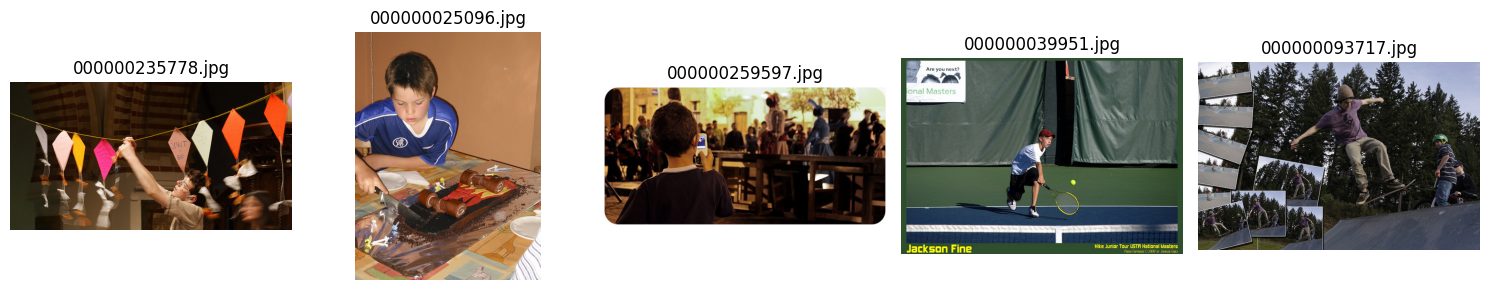

In [37]:
def show_images_from_list(image_filenames, image_folder="E:/Download/val2017", max_images=5):
    if not image_filenames:
        print("Không có ảnh nào để hiển thị.")
        return

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(image_filenames[:max_images]):
        path = os.path.join(image_folder, img_name)
        if not os.path.exists(path):
            print(f"Không tìm thấy ảnh: {path}")
            continue
        img = Image.open(path)
        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị
show_images_from_list(results, image_folder="E:/Download/val2017")

Caption: a boy riding a pony
Số triplet trích được: 1
 - ('boy', 'riding', 'pony')
  'boy' → 'person' → entity_id = 748
  'riding' → 'riding' → entity_id = 851
  'pony' → 'horse' → entity_id = 497
Không tìm được ảnh giao giữa subject, object, và predicate.
→ Thử fallback theo từng thành phần riêng lẻ.

Tổng cộng 146 ảnh liên quan (ưu tiên theo tần suất xuất hiện):
 - 000000360960.jpg
 - 000000029187.jpg
 - 000000243204.jpg
 - 000000301061.jpg
 - 000000553990.jpg
 - 000000161799.jpg
 - 000000300039.jpg
 - 000000468501.jpg
 - 000000450075.jpg
 - 000000523807.jpg

Ảnh phù hợp theo mức độ ưu tiên: ['000000360960.jpg', '000000029187.jpg', '000000243204.jpg', '000000301061.jpg', '000000553990.jpg', '000000161799.jpg', '000000300039.jpg', '000000468501.jpg', '000000450075.jpg', '000000523807.jpg', '000000331817.jpg', '000000009772.jpg', '000000439854.jpg', '000000027696.jpg', '000000576052.jpg', '000000535094.jpg', '000000576566.jpg', '000000086582.jpg', '000000289343.jpg', '000000484415.jpg'

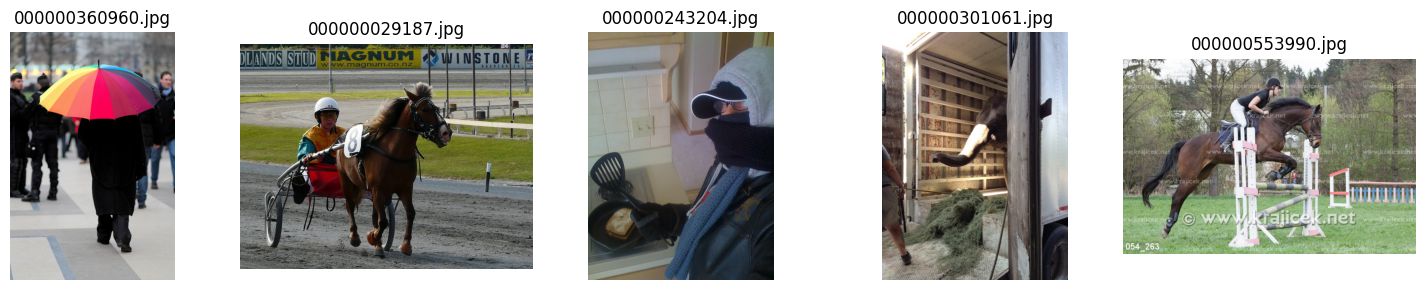

In [61]:
caption = "a boy riding a pony"
results = find_images_by_entities_prioritize_intersection(
    caption=caption,
    entity_encoder=entity_encoder,
    entity_idx_to_images=entity_idx_to_images,
    synonym_map=synonym_map
)

print("\nẢnh phù hợp theo mức độ ưu tiên:", results)

import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images_from_list(image_filenames, image_folder="E:/Download/val2017", max_images=5):
    if not image_filenames:
        print("Không có ảnh nào để hiển thị.")
        return

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(image_filenames[:max_images]):
        path = os.path.join(image_folder, img_name)
        if not os.path.exists(path):
            print(f"Không tìm thấy ảnh: {path}")
            continue
        img = Image.open(path)
        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị
show_images_from_list(results, image_folder="E:/Download/val2017")

In [62]:
caption = "a boy riding"
results = find_images_by_entities_prioritize_intersection(
    caption=caption,
    entity_encoder=entity_encoder,
    entity_idx_to_images=entity_idx_to_images,
    synonym_map=synonym_map
)

print("\nẢnh phù hợp theo mức độ ưu tiên:", results)

Caption: a boy riding
Số triplet trích được: 1
 - ('boy', 'riding', None)
  'boy' → 'person' → entity_id = 748
  'riding' → 'riding' → entity_id = 851

Tổng cộng 124 ảnh liên quan (ưu tiên theo tần suất xuất hiện):
 - 000000360960.jpg
 - 000000509699.jpg
 - 000000243204.jpg
 - 000000301061.jpg
 - 000000553990.jpg
 - 000000161799.jpg
 - 000000300039.jpg
 - 000000148739.jpg
 - 000000558854.jpg
 - 000000051976.jpg

Ảnh phù hợp theo mức độ ưu tiên: ['000000360960.jpg', '000000509699.jpg', '000000243204.jpg', '000000301061.jpg', '000000553990.jpg', '000000161799.jpg', '000000300039.jpg', '000000148739.jpg', '000000558854.jpg', '000000051976.jpg', '000000000785.jpg', '000000468501.jpg', '000000255483.jpg', '000000450075.jpg', '000000523807.jpg', '000000380706.jpg', '000000377635.jpg', '000000570664.jpg', '000000331817.jpg', '000000030504.jpg', '000000426795.jpg', '000000009772.jpg', '000000439854.jpg', '000000027696.jpg', '000000248112.jpg', '000000462643.jpg', '000000576052.jpg', '000000535

In [63]:
caption = "riding a pony"
results = find_images_by_entities_prioritize_intersection(
    caption=caption,
    entity_encoder=entity_encoder,
    entity_idx_to_images=entity_idx_to_images,
    synonym_map=synonym_map
)

print("\nẢnh phù hợp theo mức độ ưu tiên:", results)

Caption: riding a pony
Số triplet trích được: 0
Không trích được triplet. Thử fallback dựa trên từ khóa riêng lẻ.
  'riding' → 'riding' → entity_id = 851
  'horse' → 'horse' → entity_id = 497

Tìm được 33 ảnh bằng fallback (predicate + object):
 - 000000029187.jpg
 - 000000097924.jpg
 - 000000244099.jpg
 - 000000553990.jpg
 - 000000427655.jpg
 - 000000454798.jpg
 - 000000054931.jpg
 - 000000506656.jpg
 - 000000463522.jpg
 - 000000439715.jpg

Ảnh phù hợp theo mức độ ưu tiên: ['000000029187.jpg', '000000097924.jpg', '000000244099.jpg', '000000553990.jpg', '000000427655.jpg', '000000454798.jpg', '000000054931.jpg', '000000506656.jpg', '000000463522.jpg', '000000439715.jpg', '000000380203.jpg', '000000481582.jpg', '000000576052.jpg', '000000576955.jpg', '000000212800.jpg', '000000308545.jpg', '000000226883.jpg', '000000199236.jpg', '000000012748.jpg', '000000368335.jpg', '000000348243.jpg', '000000047571.jpg', '000000015956.jpg', '000000574297.jpg', '000000441442.jpg', '000000040036.jpg', 

In [64]:
caption = "a boy"
results = find_images_by_entities_prioritize_intersection(
    caption=caption,
    entity_encoder=entity_encoder,
    entity_idx_to_images=entity_idx_to_images,
    synonym_map=synonym_map
)

print("\nẢnh phù hợp theo mức độ ưu tiên:", results)

Caption: a boy
Số triplet trích được: 1
 - ('boy', None, None)
  'boy' → 'person' → entity_id = 748

Tổng cộng 123 ảnh liên quan (ưu tiên theo tần suất xuất hiện):
 - 000000360960.jpg
 - 000000509699.jpg
 - 000000243204.jpg
 - 000000301061.jpg
 - 000000553990.jpg
 - 000000161799.jpg
 - 000000300039.jpg
 - 000000148739.jpg
 - 000000558854.jpg
 - 000000051976.jpg

Ảnh phù hợp theo mức độ ưu tiên: ['000000360960.jpg', '000000509699.jpg', '000000243204.jpg', '000000301061.jpg', '000000553990.jpg', '000000161799.jpg', '000000300039.jpg', '000000148739.jpg', '000000558854.jpg', '000000051976.jpg', '000000000785.jpg', '000000468501.jpg', '000000255483.jpg', '000000450075.jpg', '000000523807.jpg', '000000380706.jpg', '000000377635.jpg', '000000570664.jpg', '000000331817.jpg', '000000030504.jpg', '000000426795.jpg', '000000009772.jpg', '000000439854.jpg', '000000027696.jpg', '000000248112.jpg', '000000462643.jpg', '000000576052.jpg', '000000535094.jpg', '000000576566.jpg', '000000086582.jpg', '

In [65]:
caption = "a boy, a pony"
results = find_images_by_entities_prioritize_intersection(
    caption=caption,
    entity_encoder=entity_encoder,
    entity_idx_to_images=entity_idx_to_images,
    synonym_map=synonym_map
)

print("\nẢnh phù hợp theo mức độ ưu tiên:", results)

Caption: a boy, a pony
Số triplet trích được: 1
 - ('boy', None, None)
  'boy' → 'person' → entity_id = 748

Tổng cộng 123 ảnh liên quan (ưu tiên theo tần suất xuất hiện):
 - 000000360960.jpg
 - 000000509699.jpg
 - 000000243204.jpg
 - 000000301061.jpg
 - 000000553990.jpg
 - 000000161799.jpg
 - 000000300039.jpg
 - 000000148739.jpg
 - 000000558854.jpg
 - 000000051976.jpg

Ảnh phù hợp theo mức độ ưu tiên: ['000000360960.jpg', '000000509699.jpg', '000000243204.jpg', '000000301061.jpg', '000000553990.jpg', '000000161799.jpg', '000000300039.jpg', '000000148739.jpg', '000000558854.jpg', '000000051976.jpg', '000000000785.jpg', '000000468501.jpg', '000000255483.jpg', '000000450075.jpg', '000000523807.jpg', '000000380706.jpg', '000000377635.jpg', '000000570664.jpg', '000000331817.jpg', '000000030504.jpg', '000000426795.jpg', '000000009772.jpg', '000000439854.jpg', '000000027696.jpg', '000000248112.jpg', '000000462643.jpg', '000000576052.jpg', '000000535094.jpg', '000000576566.jpg', '000000086582

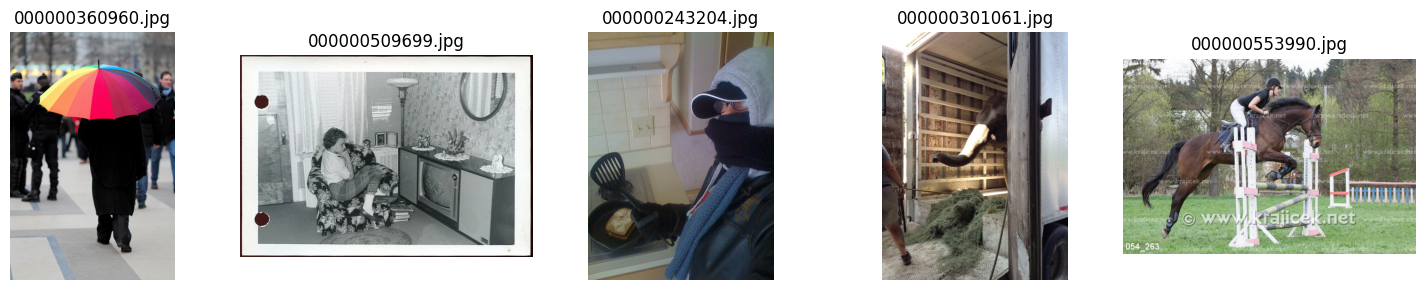

In [66]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images_from_list(image_filenames, image_folder="E:/Download/val2017", max_images=5):
    if not image_filenames:
        print("Không có ảnh nào để hiển thị.")
        return

    plt.figure(figsize=(15, 3))
    for i, img_name in enumerate(image_filenames[:max_images]):
        path = os.path.join(image_folder, img_name)
        if not os.path.exists(path):
            print(f"Không tìm thấy ảnh: {path}")
            continue
        img = Image.open(path)
        plt.subplot(1, max_images, i + 1)
        plt.imshow(img)
        plt.title(img_name)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Gọi hàm để hiển thị
show_images_from_list(results, image_folder="E:/Download/val2017")

In [88]:
import streamlit as st
import os
from PIL import Image
import matplotlib.pyplot as plt
import pickle
import numpy as np
from collections import Counter
import spacy

# === Load spaCy và các đối tượng cần thiết ===
nlp = spacy.load("en_core_web_sm")

with open("saved_model_R_GCN/entity_encoder.pkl", "rb") as f:
    entity_encoder = pickle.load(f)
with open("saved_model_R_GCN/entity_idx_to_images.pkl", "rb") as f:
    entity_idx_to_images = pickle.load(f)
with open("saved_model_R_GCN/synonym_map.pkl", "rb") as f:
    synonym_map = pickle.load(f)

# === Hàm trích triplet ===
def extract_multiple_triplets_from_caption(caption):
    doc = nlp(caption)
    subjects, predicate, objects = [], None, []
    noun_candidates = [t for t in doc if t.pos_ == "NOUN"]
    if noun_candidates:
        first_noun = noun_candidates[0]
        subjects.append(first_noun.text.lower())
        for token in noun_candidates[1:]:
            if token.dep_ == "conj" or token.head == first_noun:
                subjects.append(token.text.lower())
    for token in doc:
        if token.dep_ == "ROOT" and token.pos_ == "VERB":
            predicate = token.text.lower()
            break
    if predicate is None:
        for token in doc:
            if token.dep_ == "acl" and token.pos_ == "VERB":
                predicate = token.text.lower()
                break
    for token in doc:
        if token.dep_ in ("dobj", "pobj", "attr") and token.pos_ == "NOUN":
            objects.append(token.text.lower())
        elif token.dep_ == "conj" and token.head.dep_ in ("dobj", "pobj", "attr"):
            objects.append(token.text.lower())
    if predicate is None and not objects:
        for token in doc:
            if token.dep_ == "prep":
                pobj = next((t for t in token.children if t.dep_ == "pobj" and t.pos_ == "NOUN"), None)
                if pobj:
                    objects.append(pobj.text.lower())
    triplets = []
    if subjects and objects:
        for subj in subjects:
            for obj in objects:
                triplets.append((subj, predicate, obj))
    elif subjects:
        triplets = [(subj, predicate, None) for subj in subjects]
    return triplets

# === Hàm tìm ảnh ===
def find_images_by_entities_prioritize_intersection(caption, entity_encoder, entity_idx_to_images, synonym_map):
    triplets = extract_multiple_triplets_from_caption(caption)

    def normalize(word):
        if not word:
            return None
        word_lower = word.lower()
        word_norm = synonym_map.get(word_lower, word_lower)
        if word_norm in entity_encoder.classes_:
            return word_norm
        if word_norm.endswith("ing"):
            root = word_norm[:-3]
            if root in entity_encoder.classes_:
                return root
        lemma = nlp(word_norm)[0].lemma_
        if lemma in entity_encoder.classes_:
            return lemma
        return word_norm

    def get_id(word, label, raw_word):
        if word:
            try:
                idx = entity_encoder.transform([word])[0]
                return idx
            except:
                pass
        return None

    image_counter = Counter()
    if not triplets:
        doc = nlp(caption)
        verb, noun = None, None
        for token in doc:
            if token.pos_ == "VERB" and not verb:
                verb = normalize(token.text)
            elif token.pos_ == "NOUN" and not noun:
                noun = normalize(token.text)
        pred_id = get_id(verb, "predicate (fallback)", verb)
        obj_id = get_id(noun, "object (fallback)", noun)
        imgs_riding = set(entity_idx_to_images.get(pred_id, [])) if pred_id is not None else set()
        imgs_object = set(entity_idx_to_images.get(obj_id, [])) if obj_id is not None else set()
        inter_imgs = imgs_riding & imgs_object
        imgs = inter_imgs if inter_imgs else imgs_riding | imgs_object
        if not imgs:
            return []
        return [f"{int(img_id):012}.jpg" for img_id in imgs]

    for subj_raw, pred_raw, obj_raw in triplets:
        subj = normalize(subj_raw)
        pred = normalize(pred_raw)
        obj = normalize(obj_raw)
        subj_id = get_id(subj, "subject", subj_raw)
        pred_id = get_id(pred, "predicate", pred_raw)
        obj_id = get_id(obj, "object", obj_raw)
        imgs = set()
        if subj_id is not None and obj_id is not None:
            subj_imgs = set(entity_idx_to_images.get(subj_id, []))
            obj_imgs = set(entity_idx_to_images.get(obj_id, []))
            core_imgs = subj_imgs & obj_imgs
            if pred_id is not None:
                pred_imgs = set(entity_idx_to_images.get(pred_id, []))
                imgs = core_imgs & pred_imgs or core_imgs
            else:
                imgs = core_imgs
        elif subj_id is not None and pred_id is not None:
            subj_imgs = set(entity_idx_to_images.get(subj_id, []))
            pred_imgs = set(entity_idx_to_images.get(pred_id, []))
            imgs = subj_imgs & pred_imgs or subj_imgs | pred_imgs
        elif obj_id is not None and pred_id is not None:
            obj_imgs = set(entity_idx_to_images.get(obj_id, []))
            pred_imgs = set(entity_idx_to_images.get(pred_id, []))
            imgs = obj_imgs & pred_imgs or obj_imgs | pred_imgs
        elif subj_id is not None:
            imgs = set(entity_idx_to_images.get(subj_id, []))
        elif obj_id is not None:
            imgs = set(entity_idx_to_images.get(obj_id, []))
        image_counter.update(imgs)

    if not image_counter:
        return []
    sorted_image_ids = [img_id for img_id, _ in image_counter.most_common()]
    return [f"{int(img_id):012}.jpg" for img_id in sorted_image_ids]

# === Streamlit UI ===
st.title("Tìm ảnh liên quan từ Caption")

caption = st.text_input("Nhập caption (ví dụ: 'a man riding a horse')")

if st.button("Tìm ảnh"):
    if not caption.strip():
        st.warning("Vui lòng nhập caption.")
    else:
        results = find_images_by_entities_prioritize_intersection(
            caption=caption,
            entity_encoder=entity_encoder,
            entity_idx_to_images=entity_idx_to_images,
            synonym_map=synonym_map
        )

        if results:
            st.success(f"Tìm thấy {len(results)} ảnh. Hiển thị top 5:")
            cols = st.columns(min(5, len(results)))
            for i, img_name in enumerate(results[:5]):
                img_path = os.path.join("E:/Download/val2017", img_name)
                if os.path.exists(img_path):
                    with cols[i]:
                        st.image(Image.open(img_path), caption=img_name, use_column_width=True)
                else:
                    st.error(f"Không tìm thấy {img_name}")
        else:
            st.warning("Không tìm thấy ảnh nào phù hợp.")


2025-06-05 18:24:14.203 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-05 18:24:14.255 
  command:

    streamlit run C:\Users\admin\anaconda3\envs\coco_kg\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-06-05 18:24:14.258 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-05 18:24:14.259 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-05 18:24:14.260 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-05 18:24:14.261 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-05 18:24:14.262 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-05 18:24:14.263 Session st